# Introduction

Airbnb is one of the most popular online community marketplace for people ('hosts) to list properties, book experiences and discover places. Hosts are reponsible for setting prices for the listings. It is hard for newcomers to set an accurate price to compete with other experience hosts. 

As one of the most popular cities in Europe, London has over 80,000 listings as of May 2019. In such fierce competition environments, it is important to know which factors driving the price of listings. In this post, we will perform data analysis to extract useful insights about rental landscape in London. And applying machine learning models to predict the price for listings in London. 


## Dataset

[Inside Airbnb](http://insideairbnb.com/get-the-data.html) has provided data that is sourced from public available infomration from Airbnb webiste. The data we used for this project is compiled on 05 May, 2019. The dataset comprised of three tables and a geojson file of London boroughs:
* `listings` - Deatailed listings data for London
* `calendar` - Deatailed bookings for the next calendar year of listings
* `reviews` - Detailed reviews data for listings in London.
* `neigbourhoods` - geojson file of boroughs of London.

### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
from pprint import pprint
import datetime
from src.util import *



from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from catboost import CatBoostRegressor

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

%matplotlib inline

# Analysis/Modeling

## Listings Data

In [2]:
df_listings = load_csv('data/listings.csv.gz')

In [3]:
print(f'There are {df_listings.shape[0]} number of listings in London as of {df_listings.last_scraped.max()}')

There are 80767 number of listings in London as of 2019-05-07


In [4]:
df_listings.isna().mean().sort_values(ascending=False)[:20]

jurisdiction_names              1.000000
neighbourhood_group_cleansed    1.000000
xl_picture_url                  1.000000
host_acceptance_rate            1.000000
medium_url                      1.000000
thumbnail_url                   1.000000
license                         0.997920
square_feet                     0.994503
monthly_price                   0.931643
weekly_price                    0.903946
notes                           0.609791
access                          0.436701
interaction                     0.425260
house_rules                     0.416160
host_about                      0.416098
neighborhood_overview           0.371761
transit                         0.371600
security_deposit                0.353857
host_response_rate              0.314510
host_response_time              0.314510
dtype: float64

### EDA and Feature Selection

* Clearly, we have to drop columns that have over 90% of missing values. This include `jurisdiction_names`, `neighbourhood_group_cleansed`, `xl_picture_url`, `host_acceptance_rate`, `medium_url`, `thumbnail_url`, `license`, `square_feet`, `monthly_price and weekly_price`.
* `listing_url`, `scrape_id`, `last_scraped`, `calendar_updated`, `host_since` can also be dropped because it does not contribute to price prediction.
* `is_location_exact` , `host_neighbourhood`, `street`, `neighbourhood`, `city`, `state`, `zipcode`, `market`, `smart_location`, `country_code` `country`, `latitude` and `longitude` will also be dropped. Most of these infomrations are overlapped. We only retain the `neighbourhood_cleansed` column which contains the borough of each listings.                       
* In this project, we are not using NLP to predict price, so text columns such as `name`, `summary`, `space`, `description`, `host_verifications`, `house_rules` can be dropped.
* `first_reviews` and `last_reviews` will also be dropped because not many people look at the time of the reviews. People are more concerned with the number of reviews when they looking for listings.
* `number_of_reviews` is highly correlated with `number_of_reviews_ltm` and `reviews_per_month` and thus can be dropped.
*

In [5]:
df_listings = df_listings.drop(['jurisdiction_names', 'neighbourhood_group_cleansed', 'xl_picture_url', 'host_acceptance_rate',
                               'medium_url', 'thumbnail_url', 'license', 'square_feet', 'monthly_price', 'weekly_price',
                               'listing_url', 'scrape_id', 'last_scraped', 'calendar_updated', 'house_rules'], axis=1)

In [6]:
df_listings = df_listings.drop(['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
                                'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                                'host_neighbourhood', 'city', 'street', 'neighbourhood', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country',
                                'longitude', 'latitude', 'calendar_last_scraped', 'host_verifications', 'is_location_exact', 'host_since', 'first_review',
                                'last_review', 'bed_type', 'number_of_reviews_ltm', 'reviews_per_month'], axis=1)

* Minimum nights is highly correlated with `minimum_minimum_nights`, `maximum_minum_nights` and `minimum_nights_avg_ntm`. Likewise, Maximum nights is highly correlated with `minimum_maximum_nights`, `maximum_maximum_nights` and `maximum_nights_avg_ntm`. Thus we can keep only the `minimum_nights` and `maximum_nights` columns

* `host_listings_count` is highly correlated with `host_total_listings_count`, `calculated_host_listings_count`, and `calculated_host_listings_count_entire_homes`. so we only need to keep `host_listings_count`.

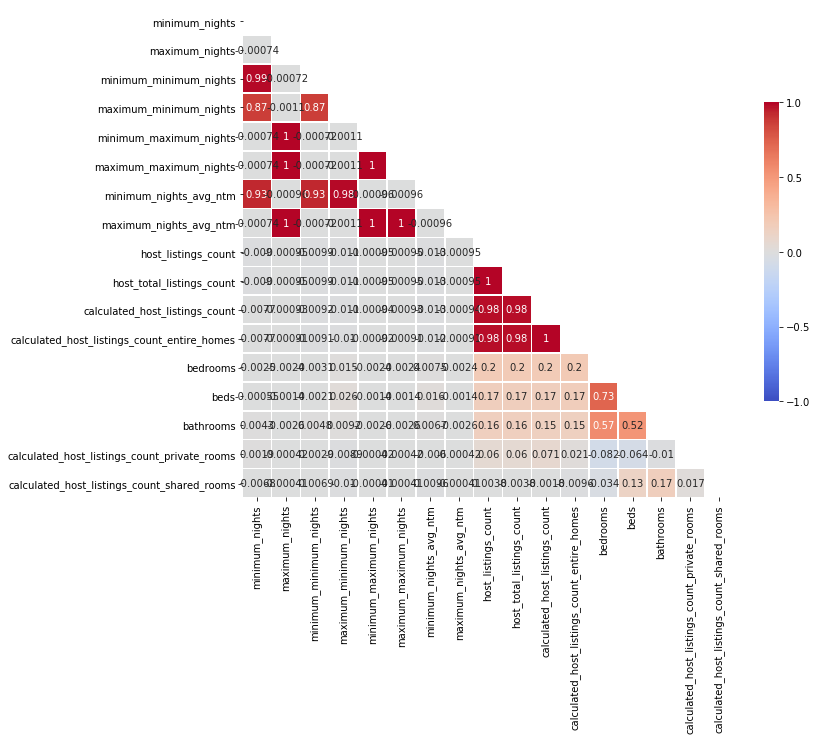

In [7]:
filtered_col = ['minimum_nights', 'maximum_nights',
              'minimum_minimum_nights', 'maximum_minimum_nights',
              'minimum_maximum_nights', 'maximum_maximum_nights',
              'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
              'host_listings_count', 'host_total_listings_count',
              'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
              'bedrooms', 'beds', 'bathrooms', 'calculated_host_listings_count_private_rooms',
              'calculated_host_listings_count_shared_rooms',
              ]
annotated_heatmap(df_listings, filtered_col)

In [8]:
df_listings = df_listings.drop(['minimum_minimum_nights', 'maximum_minimum_nights',
                                'minimum_maximum_nights', 'maximum_maximum_nights',
                                'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
                                'host_total_listings_count', 'calculated_host_listings_count',
                                'calculated_host_listings_count_entire_homes', 'beds',
                                'calculated_host_listings_count_private_rooms',
                                'calculated_host_listings_count_shared_rooms'], axis=1)

#### Has Availability

* The has availability column has contain only one category, thus it is reducdant and can be dropped.
* `availability_30`, `availability_60`, `availability_90` and `availability_365` are highly correlated and thus we only need to keep one column. Moreover, Airbnb impose a 90-day renting limit to all listings across London. So `availability_90` is kept in this case

In [9]:
df_listings['has_availability'].value_counts()

t    80767
Name: has_availability, dtype: int64

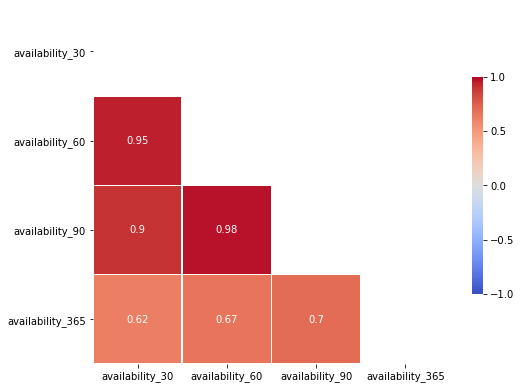

In [10]:
availability_col = ['availability_30', 'availability_60', 'availability_90', 'availability_365' ]
annotated_heatmap(df_listings, availability_col, figsize=(8, 8))

In [11]:
df_listings = df_listings.drop(['has_availability', 'availability_30', 'availability_60', 'availability_365'], axis=1)

#### Experience offered

* Most of the listings have no experience offered and thus can be dropped

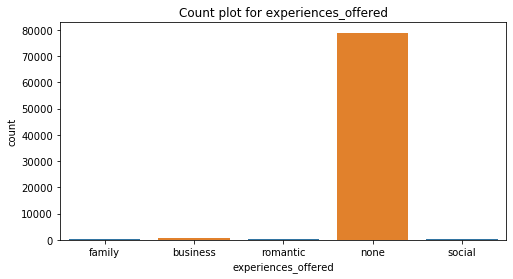

In [12]:
c_palette = ['tab:blue', 'tab:orange']
plot_categorical(df_listings, x='experiences_offered', filename='experience_count', palette=c_palette, figsize=(8,4))

In [13]:
df_listings = df_listings.drop(['experiences_offered'], axis=1)

#### host related features

* About a third of the listings have nan value which means these listings have not yet be reviewed. 65% of the listings response within a day. This is good enough for most people. Moreover, `host_response_rate` is pretty similar to `host_response_time` and people often look at `host_response_rate` when they consider to make the bookings. Thus, this measure can be dropped.

* About 31.5% of listings have not yet provided `host_reponse_rate`. It may not be appropiate to remove these listings or filling them with median or mean. We instead turing this column into discrete chunks to be used as ordinal categorical variables.

* There are 49 rows lacking values for `host_is_superhost`, `host_identity_verified`, `host_has_profile_pic`, `host_listings_count` features. We can use the mode of these columns to fill the missing values. 

In [14]:
df_listings.host_response_time.fillna("unknown", inplace=True)
df_listings.host_response_time.value_counts(normalize=True)

within an hour        0.422834
unknown               0.314510
within a few hours    0.138831
within a day          0.100821
a few days or more    0.023004
Name: host_response_time, dtype: float64

In [15]:
df_listings = df_listings.drop(['host_response_time'], axis=1)

In [16]:
print(f"The proportion of nan values in host_response rate column is around "
      f"{round(df_listings.host_response_rate.isna().sum() / len(df_listings) * 100, 1)}%")

The proportion of nan values in host_response rate column is around 31.5%


In [17]:
def bin_column(df, col, bins, labels, na_label='unknown'):
    """
    Takes a column, and segment continuous data into discrete bins with group of 
    labels and fill the na value of the column according to na_label
    
    Argument
    ========
    df: pandas dataframe
    col: str, column of dataframe
    bins: int, the criteria to bin by
    labels: arrays, specify labels for the returned bins
    na_label: values to replace missing values in col
    
    Returns
    """
    
    if df[col].dtype == 'O':
        df[col] = df[col].str[:-1].astype('float64')
        
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].replace('nan', 'unknown', inplace=True)
    df[col].fillna(na_label, inplace=True)
    

def clean_listings(df):
    """
    Remove the dollar size in the price col, fill nan value with 0 for price col
    and median for room_col, and drop rows for host_col

    Argument
    ========
    df: pandas dataframe

    Returns
    Cleaned dataframe

    """

    price_col = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']
    room_col = ['bathrooms', 'bedrooms']
    host_col = ['host_is_superhost', 'host_identity_verified',
                'host_has_profile_pic', 'host_listings_count']

    df1 = df.copy()

    df1[price_col] = df1[price_col].apply(lambda x: x.str[1:], axis=0)
    df1[price_col] = df1[price_col].apply(
        lambda x: x.str.replace(",", '')).astype('float64')
    df1[price_col] = df1[price_col].fillna(value=0)

    df1[room_col] = df1[room_col].fillna(df1[room_col].median())
    df1.dropna(subset=host_col, inplace=True)

    return df1

In [18]:
df_listings[['host_is_superhost', 'host_identity_verified',
    'host_has_profile_pic', 'host_listings_count']].isna().sum()

host_is_superhost         49
host_identity_verified    49
host_has_profile_pic      49
host_listings_count       49
dtype: int64

In [19]:
bin_column(df_listings, 'host_response_rate',
          bins=[0, 50, 75, 90, 100], 
          labels=['0-49%', '50-74%',
                  '75-89%', '90-100%'],
          )

In [20]:
df_listings = clean_listings(df_listings)

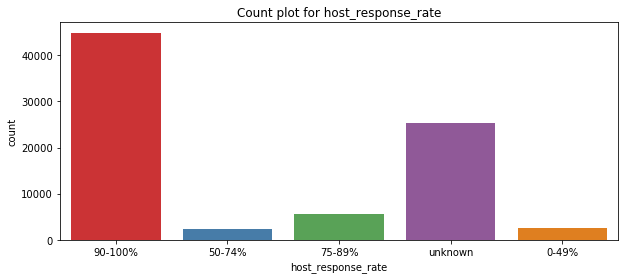

In [21]:
plot_categorical(df_listings, 'host_response_rate', 'host_response.png', hue=None, palette='Set1', figsize=(10,4))

#### Location


In [22]:
df_listings.neighbourhood_cleansed.value_counts()

Westminster               9059
Tower Hamlets             7749
Hackney                   5947
Kensington and Chelsea    5719
Camden                    5683
Islington                 4948
Southwark                 4746
Lambeth                   4670
Wandsworth                4082
Hammersmith and Fulham    4039
Brent                     2370
Lewisham                  2246
Haringey                  2073
Newham                    1887
Ealing                    1599
Greenwich                 1590
Barnet                    1532
Merton                    1326
Waltham Forest            1324
Richmond upon Thames      1147
Croydon                   1067
Hounslow                   998
Bromley                    650
Redbridge                  646
Enfield                    587
Hillingdon                 586
Kingston upon Thames       526
Harrow                     451
City of London             436
Barking and Dagenham       315
Sutton                     259
Bexley                     242
Havering

In [23]:
borough_geo = 'data/neighbourhoods.geojson'
borough_df = pd.DataFrame(df_listings.groupby('neighbourhood_cleansed')['review_scores_rating'].mean())
borough_df.rename(columns={0: 'review_scores_rating'}, inplace=True)
borough_df['median_price'] = df_listings.groupby('neighbourhood_cleansed').price.median()
borough_df = borough_df.reset_index()

In [24]:
borough_df.to_csv('borough_price_review.csv')

In [25]:
borough_df.sort_values(by='median_price', ascending=False)

,neighbourhood_cleansed,review_scores_rating,median_price
19,Kensington and Chelsea,91.764254,145.0
6,City of London,91.142857,143.0
32,Westminster,90.704166,130.0
5,Camden,91.874067,100.0
18,Islington,93.112554,90.0
12,Hammersmith and Fulham,92.715480,90.0
26,Richmond upon Thames,95.203242,89.0
31,Wandsworth,94.494277,84.0
27,Southwark,93.090658,79.0
11,Hackney,94.324152,72.0


In [26]:
borough_df.sort_values(by='review_scores_rating', ascending=False).head(5)

,neighbourhood_cleansed,review_scores_rating,median_price
26,Richmond upon Thames,95.203242,89.0
15,Havering,95.007407,46.0
20,Kingston upon Thames,94.778976,54.0
23,Merton,94.773148,65.0
28,Sutton,94.623596,45.0


**Whcih boroughs are more expensive, and which areas have the best reviews?**

* It is not surprised that Kensington and Chelsea borough is the most expensive borough to book a property. This borough is closed to many of the museums and department stores such as Harrods, Peter Jones and Harvey Nichols. Moreover, many of the most expensive residential properties in the world lie in this brough. The second one is the City of Westminster. This borough closes to many of the famous London landmarks, shopping areas and night-time entertainment area Soho. In general, inner london has much higher than than outer london area.

* All of the london boroughs has average score ratings higher than 90 out of 100. As opposed to the price, outer london has higher review score ratings than inner london. Richmond upon Thames is the highest scores rating borough. The borough is home to open space such as Richmond Park, Kew Gardens, Bushy Park and Old Deer Park. 

In [27]:
price_col = ['neighbourhood_cleansed', 'median_price']
price_london_map = london_map(borough_geo, borough_df, price_col, key_on='feature.properties.neighbourhood', 
                              legend='Median Price')
price_london_map

In [28]:
review_col = ['neighbourhood_cleansed', 'review_scores_rating']
review_london_map = london_map(borough_geo, borough_df, review_col, key_on='feature.properties.neighbourhood', 
                              legend='Average review scores', marker=False)
review_london_map

In [29]:
borough_df.sort_values('review_scores_rating', ascending=False)

,neighbourhood_cleansed,review_scores_rating,median_price
26,Richmond upon Thames,95.203242,89.0
15,Havering,95.007407,46.0
20,Kingston upon Thames,94.778976,54.0
23,Merton,94.773148,65.0
28,Sutton,94.623596,45.0
13,Haringey,94.520464,50.0
31,Wandsworth,94.494277,84.0
11,Hackney,94.324152,72.0
1,Barnet,94.041372,55.0
21,Lambeth,94.011255,70.0


#### Property type

* There are large number of property type that only has a few listings. We grouped similar property types into five categroies: House, Apartment, Guesthouse, Hotel, Other

* As expected, Hotel has the highest median price. Both Apartments and houses price varies a lot.

In [30]:
# group similar property type together
df_listings.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Condominium': 'Apartment',
    'Bed and breakfast': 'Guesthouse',
    'Loft': 'Apartment',
    'Guest suite': 'Guesthouse',
    'Hostel': 'Guesthouse',
    'Boutique hotel': 'Hotel',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Aparthotel': 'Hotel',
    'Cottage': 'House',
    'Aparthotel': 'Hotel',
    'Villa': 'House',
    'Tiny house': 'House',
    'Chalet': 'House',
    'Earth house': 'House',
    'Dome house': 'House'
}, inplace=True)


In [31]:
df_listings.loc[~df_listings.property_type.isin(['House', 'Apartment', 'Guesthouse', 'Hotel']), 'property_type'] = 'Other'

In [32]:
df_listings.property_type.value_counts()

Apartment     58402
House         19828
Guesthouse     1697
Other           407
Hotel           384
Name: property_type, dtype: int64

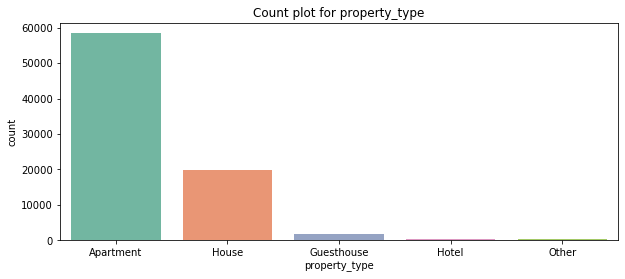

In [33]:
plot_categorical(df_listings, 'property_type', 'property_type.png', hue=None, palette='Set2', figsize=(10,4))

In [34]:
df_listings.loc[(df_listings.price <= 600) & (df_listings.price > 0)].head()

,id,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,11551,90-100%,f,3.0,t,t,Lambeth,Apartment,Entire home/apt,4,1.0,1.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",88.0,350.0,50.0,2,20.0,2,180,20,183,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,f,f,strict_14_with_grace_period,f,t
1,13913,50-74%,f,4.0,t,f,Islington,Apartment,Private room,2,1.0,1.0,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",65.0,100.0,15.0,1,15.0,1,29,87,14,95.0,9.0,10.0,9.0,10.0,9.0,9.0,f,f,f,moderate,f,f
2,15400,90-100%,f,1.0,t,t,Kensington and Chelsea,Apartment,Entire home/apt,2,1.0,1.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",100.0,150.0,50.0,2,0.0,3,50,1,84,95.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,f,strict_14_with_grace_period,t,t
3,17402,75-89%,t,16.0,t,t,Westminster,Apartment,Entire home/apt,6,2.0,3.0,"{TV,Wifi,Kitchen,""Paid parking off premises"",E...",300.0,350.0,65.0,4,10.0,3,365,17,40,93.0,10.0,9.0,9.0,9.0,10.0,9.0,f,t,f,strict_14_with_grace_period,f,f
4,24328,90-100%,t,2.0,t,t,Wandsworth,House,Entire home/apt,2,1.5,1.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",175.0,250.0,70.0,2,0.0,30,1125,57,92,98.0,10.0,10.0,10.0,10.0,9.0,9.0,f,f,f,moderate,t,t


In [35]:
def box_plot_price(x, figsize=(10, 5)):
    """
    Return ordered box plots with differet categories x against price y 
    
    Arguments
    =========
        x: categorical variable
        figsize: tuple, size of the figure
    
    """
    filtered_df = df_listings.loc[(df_listings.price <= 600) & (df_listings.price > 0)]
    sort_price = filtered_df.groupby(x)['price'].median()\
                 .sort_values(ascending=False).index
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(y='price', x=x, data=filtered_df, order=sort_price)
    ax.set_xticklabels(ax.get_xticklabels())
    

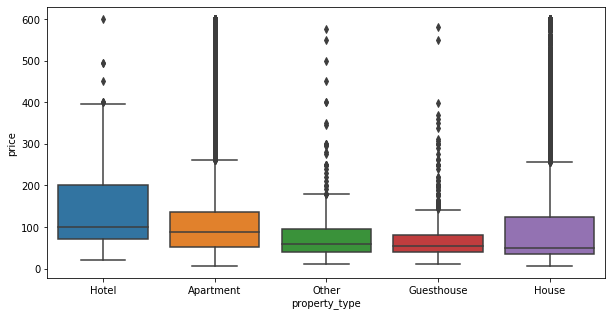

In [36]:
box_plot_price('property_type')

#### Room Type

In [37]:
df_listings.room_type.value_counts()

Entire home/apt    45046
Private room       34934
Shared room          738
Name: room_type, dtype: int64

* Entire home/apt has much higher median price than the other room types
* As expected, many of the private room has price lower than £100. Also, Entire home/apt has the most number of listings. 

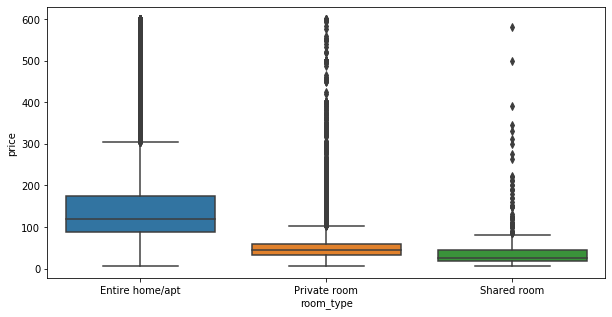

In [38]:
box_plot_price('room_type')

Text(0.5, 0, 'Listing price in $')

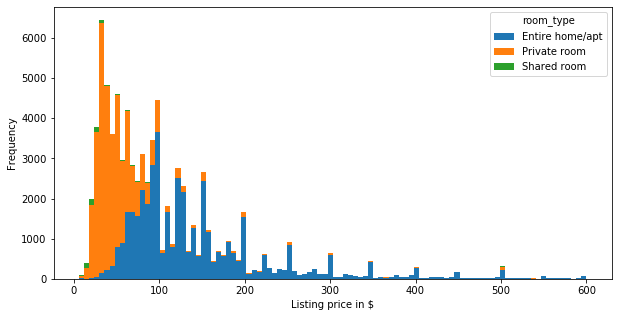

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))
df_listings.loc[(df_listings.price <= 600) & (df_listings.price > 0)]\
    .pivot(columns='room_type', values='price')\
    .plot.hist(stacked=True, bins=100, ax=ax)
plt.xlabel('Listing price in $')

#### Amenities

* Wifi, heating, essential, Washer are most common ammenities.
* We use count vectorizer to turn text into word count vectors that can be used in machine learning models.
* There are 201 features for amenities. We have to reduce the number of features. It can be done by removing categories that appear fewer than 15% of listings.


In [40]:
df_listings.amenities = df_listings.amenities.str.replace("[{}]", "").str.replace('"', "")

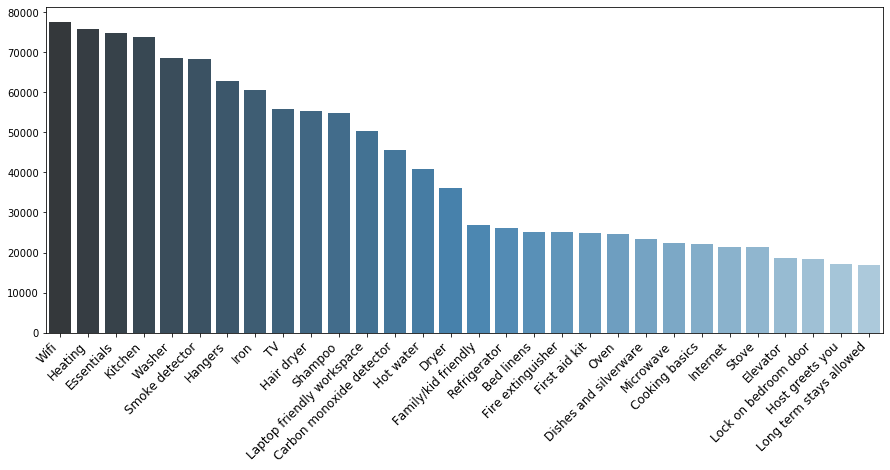

In [41]:
fig, ax = plt.subplots(figsize=(15, 6))
color = next(ax._get_lines.prop_cycler)['color']
top_30_amenities = pd.Series(np.concatenate(np.array(df_listings['amenities'].map(lambda amns: amns.split(",")))))\
          .value_counts().head(30)

sns.barplot(top_30_amenities.index, top_30_amenities.values, palette=("Blues_d"))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12);


#### Review scores columns

* review_scores columns are highly coorelated with each other, thus we can keep only one column
*


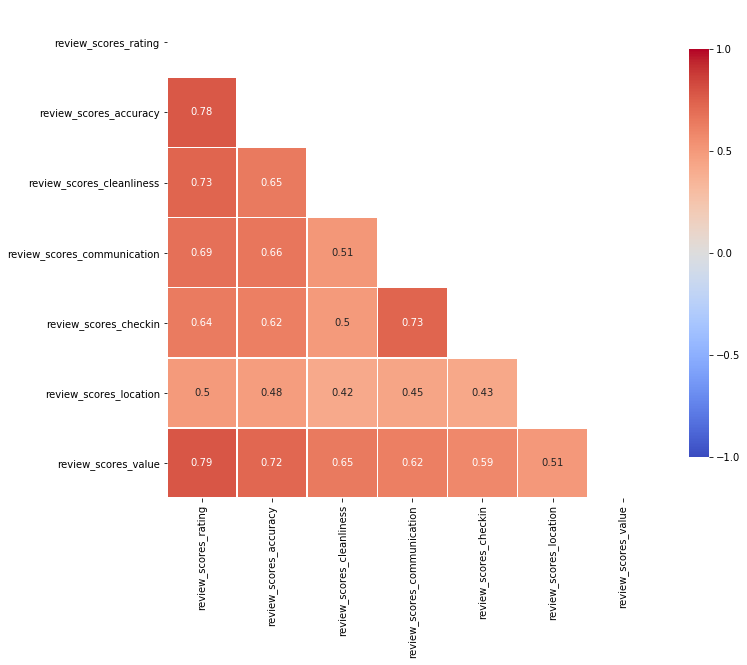

In [42]:
review_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                  'review_scores_communication', 'review_scores_checkin', 'review_scores_location', 'review_scores_value']
annotated_heatmap(df_listings, review_columns, figsize=(11, 15))

In [43]:
review_col_drop = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_value',
                   'review_scores_communication', 'review_scores_checkin', 'review_scores_location']
df_listings = df_listings.drop(review_col_drop, axis=1)

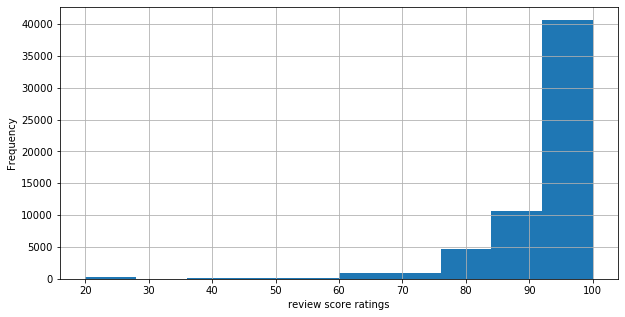

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
df_listings.review_scores_rating.hist(bins=10, ax=ax)
ax.set_xlabel('review score ratings')
ax.set_ylabel('Frequency');

In [45]:
bin_column(df_listings, 'review_scores_rating', 
          bins=[0, 80, 95, 100],
          labels=['0-79', '80-94', '95-100'],
          na_label='no reviews')

In [46]:
df_listings.cancellation_policy.value_counts()

strict_14_with_grace_period    34226
flexible                       26340
moderate                       19298
super_strict_30                  425
super_strict_60                  411
strict                             9
luxury_moderate                    9
Name: cancellation_policy, dtype: int64

###  Modelling Listing price

In this section, we first prepare data for machine learning algorithms. Count vectorizer will be used for amenities columns which contains text. One-hot encoding will be applied for categorical variables.  Next, we use random forest regressions and XGBoost to predict the listing's price. The evaluation metrics used will be RMSE and r squared.

In [145]:
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [146]:
listing_df = load_csv('data/listings.csv.gz')
price = listing_df.price
price = price.apply(lambda x: x[1:])
price = price.apply(lambda x: x.replace(",", '')).astype('float64').replace(0.0, 0.01)
price = np.log(price)

In [147]:
listing_df.drop('price', axis=1, inplace=True)

In [148]:
# X_train, X_test, y_train, y_test = train_test_split(listing_df, price, test_size=0.25, random_state=42)


In [149]:
class AmenitiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column='amenities'):
        self.column = column
        
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        
        X.loc[:, self.column] = X.loc[:, self.column].str.replace("[{}]", "").str.replace('"', "").str.strip()
        count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
        transformed_col = count_vectorizer.fit_transform(X[self.column])
        trans_col_to_df = pd.DataFrame(transformed_col.toarray(), columns=count_vectorizer.get_feature_names())
        trans_col_to_df = trans_col_to_df.drop('', axis=1)
        
        amenities_to_remove = []
        for col in trans_col_to_df.columns:
            if (trans_col_to_df[col].sum() / len(X) * 100) < 15:
                amenities_to_remove.append(col)
        
        trans_col_to_df.drop(amenities_to_remove, axis=1, inplace=True)
        
        return trans_col_to_df

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError(f"The DataFrame does not include the columns: {cols_error}")



In [150]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes in a list of values as its argument
    def __init__(self, features):
        self.features = features
    
    
    def bin_cat(self, df, col, bins, labels, na_label='unknown'):
        """
        A Helper function takes a column, and segment continuous data into discrete bins with group of 
        labels and fill the na value of the column according to na_label

        Argument
        ========
        df: pandas dataframe
        col: str, column of dataframe
        bins: int, the criteria to bin by
        labels: arrays, specify labels for the returned bins
        na_label: values to replace missing values in col

        Returns
        """

        if df.loc[:, col].dtype == 'object':
            df.loc[:, col] = df.loc[:, col].str[:-1].astype('float64')

        df.loc[:, col] = pd.cut(df.loc[:, col], bins=bins,
                                labels=labels, include_lowest=True).astype('str')
        df.loc[:, col].replace('nan', 'unknown', inplace=True)
        df.loc[:, col].fillna(na_label, inplace=True)

        return df

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):

        X = self.bin_cat(X, 'host_response_rate',
                       bins=[0, 50, 75, 90, 100],
                       labels=['0-49%', '50-74%', '75-89%', '90-100%'])

        X = self.bin_cat(X, 'review_scores_rating',
                       bins=[0, 80, 95, 100],
                       labels=['0-79', '80-94', '95-100'],
                       na_label='no reviews')

        X.property_type.replace({
            'Townhouse': 'House',
            'Serviced apartment': 'Apartment',
            'Condominium': 'Apartment',
            'Bed and breakfast': 'Guesthouse',
            'Loft': 'Apartment',
            'Guest suite': 'Guesthouse',
            'Hostel': 'Guesthouse',
            'Boutique hotel': 'Hotel',
            'Bungalow': 'House',
            'Cottage': 'House',
            'Aparthotel': 'Hotel',
            'Cottage': 'House',
            'Aparthotel': 'Hotel',
            'Villa': 'House',
            'Tiny house': 'House',
            'Chalet': 'House',
            'Earth house': 'House',
            'Dome house': 'House'
        }, inplace=True)

        X.loc[~X.property_type.isin(
            ['House', 'Apartment', 'Guesthouse', 'Hotel']), 'property_type'] = 'Other'

        df_amenities = AmenitiesTransformer().fit_transform(X)

        X = pd.concat([X, df_amenities], axis=1, join='inner')
        X = X.drop('amenities', axis=1)
        for feat in self.features:
            X.loc[:, feat] = X.loc[:, feat].fillna(X.loc[:, feat].mode()[0])

        return X


class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, price_features, room_features):
        self.price_features = price_features
        self.room_features = room_features

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        X.loc[:, self.price_features] = X.loc[:, self.price_features].apply(
            lambda x: x.str[1:])
        X.loc[:, self.price_features] = X.loc[:, self.price_features].apply(
            lambda x: x.str.replace(",", '')).astype('float64')
        X.loc[:, self.price_features] = X.loc[:, self.price_features].fillna(value=0)
        
        X.loc[:, self.room_features] = X.loc[:, self.room_features].fillna(
            X.loc[:, self.room_features].median())
        
        X.loc[:, 'host_listings_count'] = X.loc[:, 'host_listings_count'].fillna(
            X.loc[:, 'host_listings_count'].median())
        
        return X

In [151]:
feature_columns = ['id', 'host_response_rate', 'host_is_superhost', 'host_listings_count',
                   'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed',
                   'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
                   'amenities', 'security_deposit', 'cleaning_fee', 'guests_included',
                   'extra_people', 'minimum_nights', 'maximum_nights', 'availability_90',
                   'number_of_reviews', 'review_scores_rating', 'requires_license',
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
                   'require_guest_profile_picture', 'require_guest_phone_verification']

price_col = ['security_deposit', 'cleaning_fee', 'extra_people']
room_col = ['bathrooms', 'bedrooms']
numerical_transformer = Pipeline(steps=[
    ('num_tranform', NumericalTransformer(price_col, room_col))
])

category_columns = ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic']
categorical_transformer = Pipeline(steps=[
    ('cat_transform', CategoricalTransformer(category_columns))
])




In [152]:
clf = Pipeline(steps=[
    ('columnselect', ColumnSelector(feature_columns)),
    ('cat', categorical_transformer),
    ('num', numerical_transformer)
])  

In [153]:
processed_df = clf.fit_transform(listing_df)

In [154]:
# Replace True False into 1 and 0
processed_df = processed_df.replace({'f': 0, 't': 1})

In [155]:
processed_df = pd.get_dummies(processed_df)

In [156]:
X_train, X_test, y_train, y_test = train_test_split(processed_df, price, test_size=0.25, random_state=42)

In [ ]:
# df_listings_cat = pd.concat([df_listings, df_amenities], axis=1, join='inner')
# df_listings_cat['price'] =  df_listings_cat['price'].astype('float64').replace(0.0, 0.01)
# df_listings_cat['price'] = np.log(df_listings_cat['price'])
# export_csv_cat = df_listings_cat.to_csv(r'preprocessed_data/listing_cat.csv', 
#                                         index = None, header=True)

# X_cat = df_listings_cat.drop('price', axis=1)
# y_cat = df_listings_cat.price
# X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.25, random_state=42)

####  Random Forest Regressor

In [162]:
print('Training set shape', X_train.shape)
print('Training labels shape', y_train.shape)
print('Testing set shape', X_test.shape)
print('Testing labels shape', y_test.shape)

Training set shape (60575, 116)
Training labels shape (60575,)
Testing set shape (20192, 116)
Testing labels shape (20192,)


In [163]:
# Instantiate model
rf = RandomForestRegressor(n_estimators=500, 
                           random_state=42,
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [164]:
print('Parameters currently in use: \n')
pprint(rf.get_params())

Parameters currently in use: 

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


#### Random Search with Cross Validation

In [165]:
# # Numbe of trees in random forest
# n_estimators = [int(x) for x in np.linspace(200, 2000, num=5)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# pprint(random_grid)

In [166]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor(random_state = 42)
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores

# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
#                               n_iter = 20, scoring='neg_mean_squared_error', 
#                               cv = 3, verbose=2, random_state=42, n_jobs=-1,
#                               return_train_score=True)

# # Fit the random search model
# rf_random.fit(X_train, y_train);

In [167]:
#rf_random.best_params_

In [179]:
def evaluate(model, X_test, y_test):
    y_test_pred = model.predict(X_test)
    rmse_rf = (mean_squared_error(y_test, y_test_pred))**0.5
    r2score = r2_score(y_test, y_test_pred)
    adj_r2 = 1 - (1 - r2score) * (X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1)
    
    print(f'RMSE test: {rmse_rf}')
    print(f'R2 score test: {r2score}')
    print(f'Adjusted R2 score test: {adj_r2}')
    
    return rmse_rf, r2score

In [174]:
base_model = RandomForestRegressor(n_estimators=500, 
                           random_state=42,
                           n_jobs=-1)

base_model.fit(X_train, y_train)


TypeError: unsupported operand type(s) for ** or pow(): 'function' and 'int'

In [180]:
base_rmse, base_r2 = evaluate(base_model, X_test, y_test)

RMSE test: 0.3984007414910256
R2 score test: 0.7486037394240584
Adjusted R2 score test: 0.7471510885534827


In [172]:
def feature_importance_plot(X_train, model, filename):
    """Plot the feature importance and print the top 20 feature importance returned
       by the model.
       
       Arguments
       =========
           X_train: The feature matrix
           model: regression models
           filename: str, name to save the resulting plot
        
    """
    feature_list = X_train.columns
    feature_importance_df = pd.DataFrame(model.feature_importances_,
                                        columns=['Importances'],
                                        index=feature_list)
    feature_importance_df.sort_values(by='Importances', ascending=False, inplace=True)
    #print(feature_importance_df.head(20))
    
    # Reset style 
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(27, 13))

    feature_importance_df.head(20).plot(kind='barh', ax=ax,
                                   color = 'r', edgecolor = 'k')

    ax.set_title('Feature Importances')
    ax.set_ylabel('Features')
    ax.set_xlabel('Importance')
    
    plt.savefig('../images/'+filename, dpi=1200);
    
    return feature_importance_df


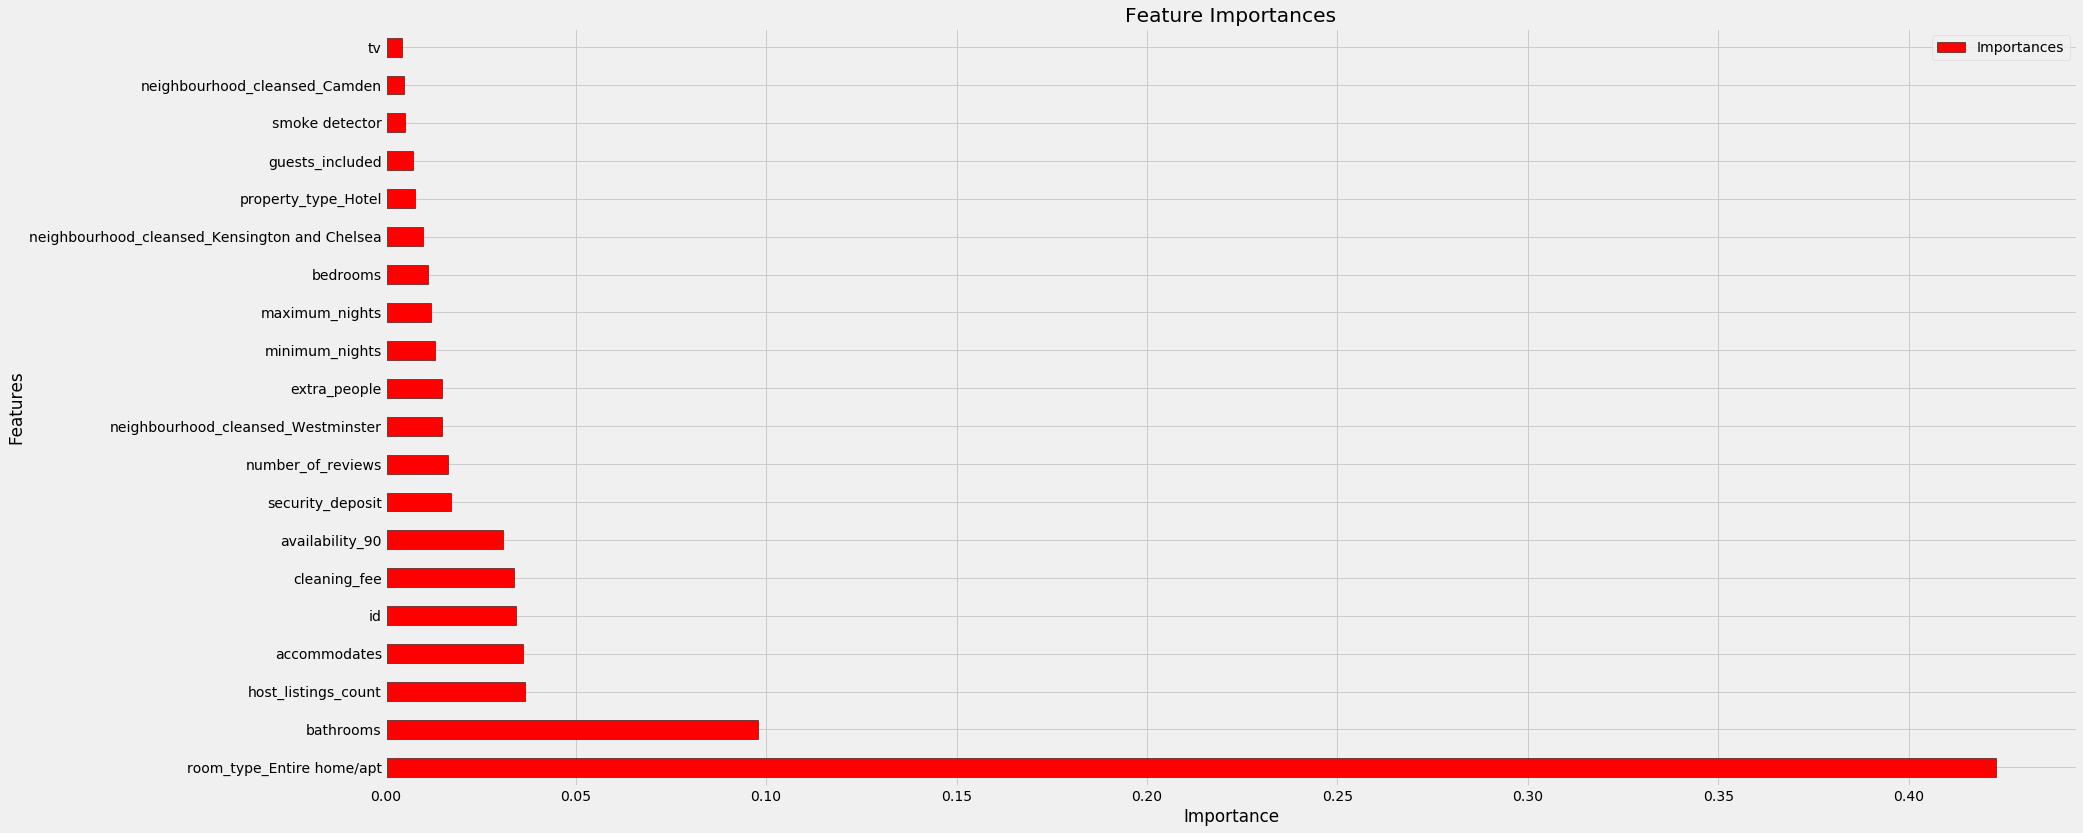

In [181]:
rf_feature_df = feature_importance_plot(X_train, base_model, 'rf_importance')

#### CatBoost

* Without hyperparameter tuning, the out-of-box algorithm is already better than the tuned random forest model

In [ ]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]

categorical = ['host_response_rate', 'neighbourhood_cleansed', 'property_type', 'room_type',
               'review_scores_rating', 'cancellation_policy']

categorical_features_indices = column_index(X_cat, categorical)

In [ ]:
model=CatBoostRegressor(loss_function='RMSE')
model.fit(X_train_cat, y_train_cat,cat_features=categorical_features_indices,eval_set=(X_test_cat, y_test_cat),plot=True, verbose=500);

In [ ]:
evaluate(model, X_test_cat, y_test_cat)

In [ ]:

# # The maximum number of trees
# iterations = [int(x) for x in np.linspace(500, 2000, num=5)]
# # Learning rate
# learning_rate = [0.03, 0.1, 0.15]


# # Create the random grid
# params = {'iterations': [int(x) for x in np.linspace(500, 2000, num=5)],
#           'learning_rate': [0.03, 0.1, 0.15],
#           'depth': [4, 8, 10],
#           'l2_leaf_reg': [1, 4],
#          }
# cb_reg = CatBoostRegressor()
# cb_grid = RandomizedSearchCV(estimator=cb_reg, param_distributions=params,
#                             n_iter=10, scoring='neg_mean_squared_error',
#                             cv=3, verbose=2, random_state=42,
#                             return_train_score=True)
# cb_grid.fit(X_train_cat, y_train_cat, cat_features=categorical_features_indices,
#             eval_set=(X_test_cat, y_test_cat))

In [ ]:
#cb_grid.best_params_

In [ ]:
best_cb = CatBoostRegressor(learning_rate=0.15, l2_leaf_reg=1, iterations=2000, depth=4)
best_cb.fit(X_train_cat, y_train_cat, cat_features=categorical_features_indices,
            eval_set=(X_test_cat, y_test_cat), verbose=100)
best_cat_rmse, best_cat_r2 = evaluate(best_cb, X_test_cat, y_test_cat)

### Feature importance

The features that contribute most to the variance in prices are:

* accommodates             
* room type                 
* Number of bedrooms                   
* cleaning fee               
* the borough the listing in   
* The number of listings the host has 
* The number of nights are avaliable to be booked in the next 90 days        
* bathrooms                  
* listing id       
* fee for extra person               

The top 2 features the number of people the property accomodates and room type contribute almost 43% to the price. This make snese because more people a property can live in, the higher the price is. It is the first thing we look at when we make a booking. Obviously if the room type is a private room, the price tends to be lower than the entire home/apartment.  

Cleaning fee and the borough the listing in are also important features that influence the price. Interestingly the number of listings the host has is in the top 10 features. Maybe because these hosts are professional property management that is more realiable than individuals. Hence, the price is more expensive.  


In [ ]:
cat_feature_df = feature_importance_plot(X_train_cat, best_cb, 'cat_importance')

In [ ]:
cat_feature_df = cat_feature_df.reset_index()
rf_feature_df = rf_feature_df.reset_index()

In [ ]:
feature_import_df = pd.merge(cat_feature_df, rf_feature_df, on=['index'])
feature_import_df.columns = ['features', 'cb_importance', 'rf_importance']
feature_import_df.rf_importance = feature_import_df.rf_importance * 100

In [ ]:
feature_import_df.to_csv('preprocessed_data/feature_importance.csv')

# Conclusions

* The demand for Airbnb increased exponentially over the years. 
* Demand increases along the year until August and slowly decrease.
* The cheapest month to book Airbnb is May.
* Richmond upon Thames borough has the highest average review score ratings.
* Our best model to predict the price is using Catboost which has a r2 score of 73.9%. This means that the model explain 73.9% of the variability in listing price. The result was not good enough. However, price is very different to predict correcly, and the remaining 26.1% may be explained by features that are not in the data. 